# Google Colab Notebook to train [Imagenette](https://github.com/fastai/imagenette)

Imagenette is a subset of 10 classes from Imagenet that are packaged up and easy to download. This notebook takes the wieghts of a ResNet34 architecture pretrained on the full Imagenet dataset as its starting point and continues training on just the 10 Imagenette categories.

This can be used as our example network for adversarial attacks and/or training for various defenses.

-Arnaldo

In [1]:
%matplotlib inline

In [2]:
!pip install -q torch==1.7.0 torchvision

In [156]:
from google.colab import drive
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import time
import copy
import imageio
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from PIL import Image

# Download dataset

You only need to run the cells below once to download the Imagenette dataset to your Google Drive.

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
if not os.path.exists("/content/gdrive/My Drive/imagenette"):
    os.mkdir("/content/gdrive/My Drive/imagenette")

In [28]:
!wget -O /content/gdrive/My\Drive/imagenette/imagenette.tgz 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz' 

--2020-11-25 20:33:09--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.226.67
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.226.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘/content/gdrive/MyDrive/imagenette/imagenette.tgz’

/content/gdrive/MyD 100%[===================>]   1.45G  78.7MB/s    in 20s     

2020-11-25 20:33:29 (74.5 MB/s) - ‘/content/gdrive/MyDrive/imagenette/imagenette.tgz’ saved [1556914727/1556914727]



In [35]:
!tar zxvf /content/gdrive/My\Drive/imagenette/imagenette.tgz -C /content/gdrive/My\Drive/imagenette/
!rm /content/gdrive/My\Drive/imagenette/imagenette.tgz

Streaming output truncated to the last 5000 lines.
imagenette2/train/n02102040/n02102040_5604.JPEG
imagenette2/train/n02102040/n02102040_1343.JPEG
imagenette2/train/n02102040/n02102040_487.JPEG
imagenette2/train/n02102040/n02102040_2516.JPEG
imagenette2/train/n02102040/n02102040_503.JPEG
imagenette2/train/n02102040/n02102040_2634.JPEG
imagenette2/train/n02102040/n02102040_5028.JPEG
imagenette2/train/n02102040/n02102040_5214.JPEG
imagenette2/train/n02102040/n02102040_3806.JPEG
imagenette2/train/n02102040/n02102040_467.JPEG
imagenette2/train/n02102040/n02102040_8208.JPEG
imagenette2/train/n02102040/n02102040_7124.JPEG
imagenette2/train/n02102040/n02102040_213.JPEG
imagenette2/train/n02102040/n02102040_35.JPEG
imagenette2/train/n02102040/n02102040_3997.JPEG
imagenette2/train/n02102040/n02102040_7617.JPEG
imagenette2/train/n02102040/n02102040_3699.JPEG
imagenette2/train/n02102040/n02102040_5136.JPEG
imagenette2/train/n02102040/n02102040_3593.JPEG
imagenette2/train/n02102040/n02102040_1148.

# Set up class dictionaries

We set up the names and class numbers for each of the object types here. Imagenette contains ten classes of objects to be identified: 

* tench (a kind of fish)
* cassette player
* church
* garbage truck
* golf ball
* English terrier
* chainsaw
* French horn
* gas pump
* parachute

In [96]:
num_classes = 10
directory_dict = {'n01440764': 'tench',
                  'n02979186': 'cassette player',
                  'n03028079': 'church',
                  'n03417042': 'garbage truck',
                  'n03445777': 'golf ball',
                  'n02102040': 'English terrier',
                  'n03000684': 'chainsaw',
                  'n03394916': 'French horn',
                  'n03425413': 'gas pump',
                  'n03888257': 'parachute'}

class_labels = {}
labels_class = {}
for i, v in enumerate(directory_dict.values()):
    class_labels.update({v: i})
    labels_class.update({i: v})

print(class_labels)

train_dir = '/content/gdrive/My Drive/imagenette/imagenette2/train'
val_dir = '/content/gdrive/My Drive/imagenette/imagenette2/val'

train_images = []
val_images = []

for k, v in directory_dict.items():
    train_images_in_dir = [(f"{train_dir}/{k}/{f}", class_labels[v])
                           for f in os.listdir(os.path.join(train_dir, k))]
    train_images += train_images_in_dir

    val_images_in_dir = [(f"{val_dir}/{k}/{f}", class_labels[v])
                         for f in os.listdir(os.path.join(val_dir, k))]
    val_images += val_images_in_dir

{'tench': 0, 'cassette player': 1, 'church': 2, 'garbage truck': 3, 'golf ball': 4, 'English terrier': 5, 'chainsaw': 6, 'French horn': 7, 'gas pump': 8, 'parachute': 9}


# Plot a few example images

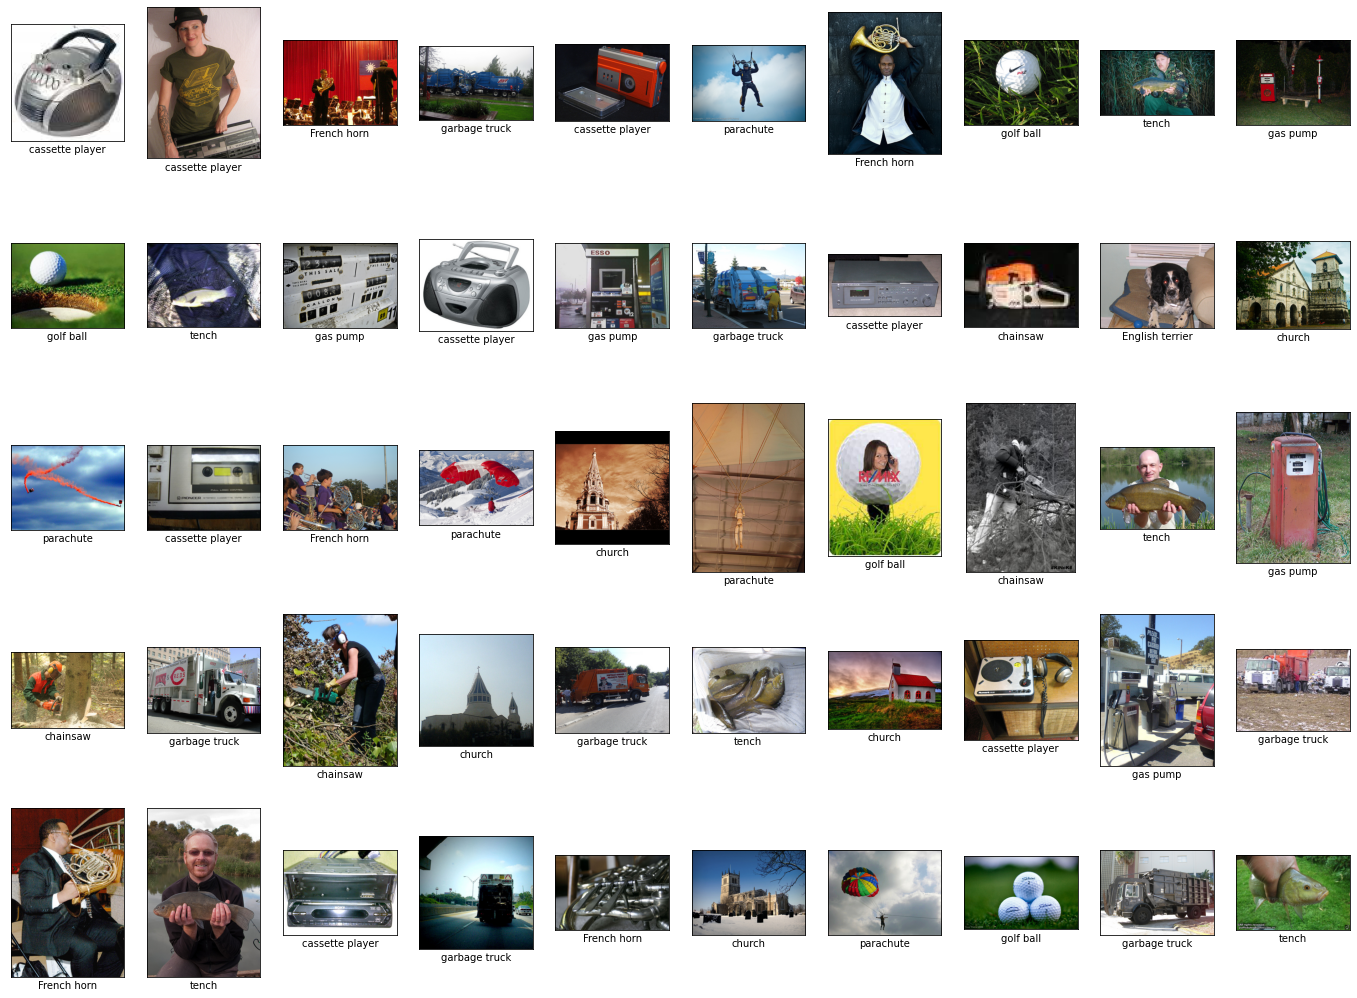

In [108]:
np.random.seed(133742)

image_samples = []

for i in range(50):
    sample_idx = np.random.choice(len(val_images))
    image_samples.append(val_images[sample_idx])

fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(24, 18))
for i in range(50):
    row = i // 10
    col = i - row * 10
    ax[row][col].imshow(imageio.imread(image_samples[i][0]))
    ax[row][col].set_xlabel(labels_class[image_samples[i][1]])
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

# Download pretrained model weights

We download the weights of a Wide Resnet 50 architecture pretrained on the entire ImageNet dataset as our starting point.

In [143]:
net_pretrained = models.wide_resnet50_2(pretrained=True)

# Transfer learning

Freeze weights in layers close to inputs (use them as fixed feature extractors)and retrain with only the 10 classes above for higher accuracy.

In [144]:
"""
This cell is generic setup
for data loading and the
training loop.
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

image_datasets = {'train': datasets.ImageFolder(train_dir,
                                          data_transforms['train']),
                  'val': datasets.ImageFolder(train_dir,
                                              data_transforms['val'])
                 }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [directory_dict[c] for c in image_datasets['train'].classes]

print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training loop function

def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

['tench', 'English terrier', 'cassette player', 'chainsaw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


# Training

Here is where we actually set our parameters to retrain the network.

First, we need to replace the output layer with an output layer that has as many nodes as the classes we want our network to classify (10, instead of the 1000 classes in ImageNet).

Then, we run the training loop above on this modified network. We will keep the weights of all layers except those closest to the output frozen, since those layers closer to the inputs are likely already useful feature extractors. We instead optimize only the parameters of the layers close to the output (including the new output layer initialized with random weights).

In [145]:
# Replace nodes of the output layer with 10 new nodes.
# Initializes with random weights between hidden layer nodes
# and this new layer of output nodes.
hidden_nodes = net_pretrained.fc.in_features
output_nodes = num_classes
net_pretrained.fc = nn.Linear(hidden_nodes, num_classes)

# Freeze all parameters in lower layers.
for idx, child in enumerate(net_pretrained.children()):
    if idx <= 6:
        for param in child.parameters():
            param.requires_grad = False

# Send to GPU for fast training on Google Colab.
net_pretrained = net_pretrained.to(device)

# Use cross entropy as loss function.
loss = nn.CrossEntropyLoss()

# Use stochastic gradient descent with momentum.
optimizer = optim.SGD(net_pretrained.parameters(), lr=0.01, momentum=0.9)

# Retrain the network for 5 epochs.
net = train_model(net_pretrained, loss, optimizer,
                  num_epochs=5)

Epoch 1/5
----------
train Loss: 0.2087 Acc: 0.9437
val Loss: 0.0135 Acc: 0.9968

Epoch 2/5
----------
train Loss: 0.1099 Acc: 0.9666
val Loss: 0.0057 Acc: 0.9989

Epoch 3/5
----------
train Loss: 0.0925 Acc: 0.9710
val Loss: 0.0045 Acc: 0.9989

Epoch 4/5
----------
train Loss: 0.0773 Acc: 0.9755
val Loss: 0.0061 Acc: 0.9981

Epoch 5/5
----------
train Loss: 0.0739 Acc: 0.9768
val Loss: 0.0019 Acc: 0.9997

Training complete in 14m 14s
Best val Acc: 0.999683


# Save the model

The cell below serializes the trained model so the trained weights can be reloaded without having to train the model again.

In [147]:
torch.save(net, '/content/gdrive/My Drive/imagenette_base_model.pt')

# Load model

You can load the model trained above to avoid having to rerun training if you have to restart the notebook for some reason.

In [148]:
net = torch.load('/content/gdrive/My Drive/imagenette_base_model.pt').to(device)

# Evaluate performance

Use network to get predictions for our sample images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


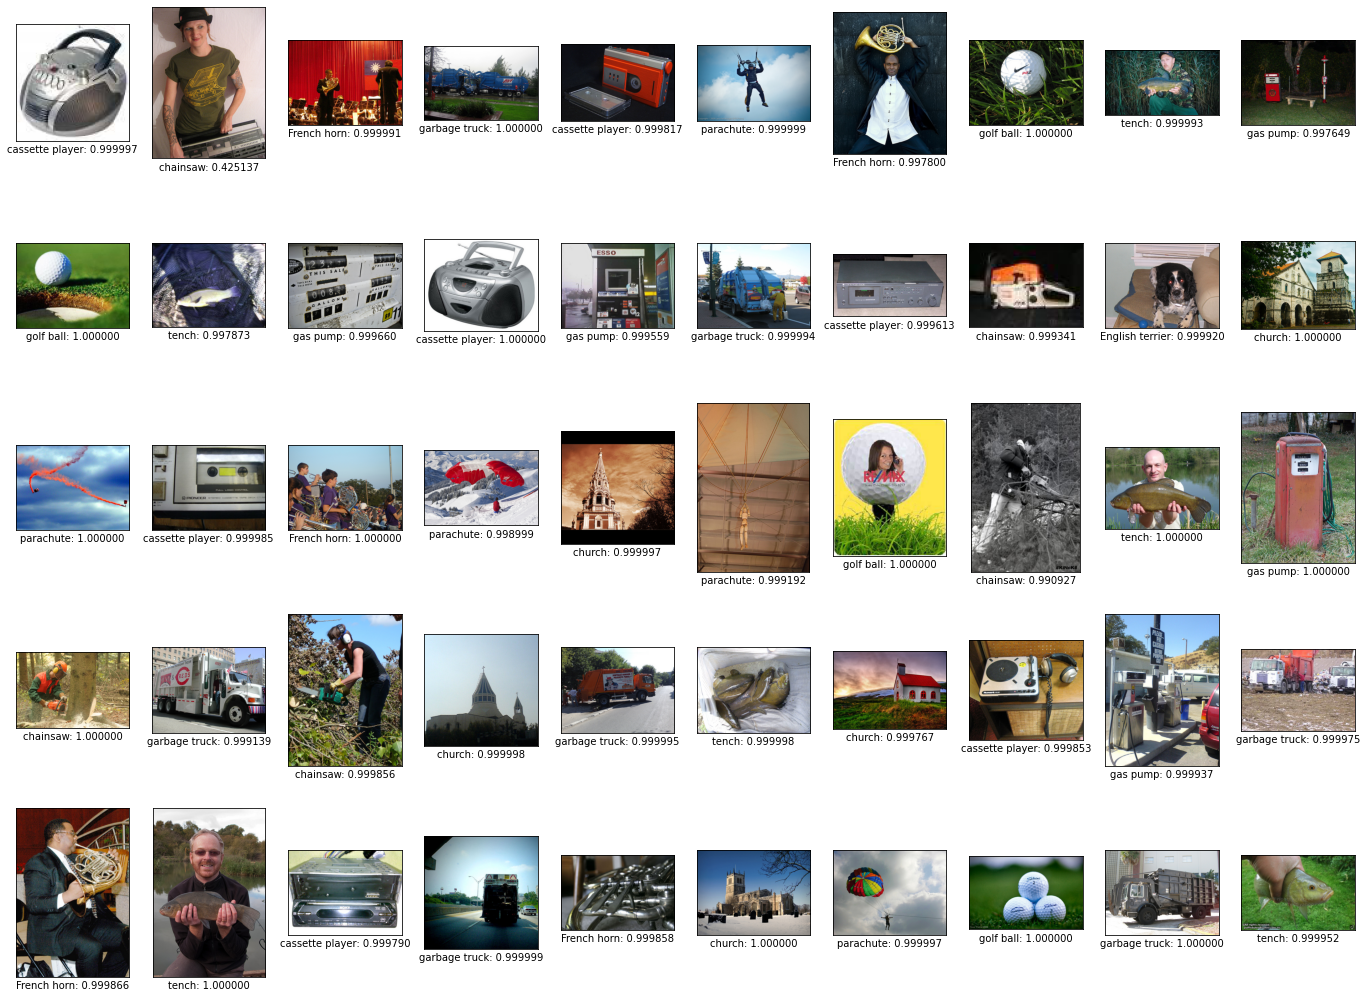

In [176]:
def predict_image(network, image_file):
    """
    Input: Image file path (str)
    Outputs: Predicted image class, probability assigned by network to top class
    """
    img = Image.open(image_file)
    input_tensor = data_transforms['val'](img).float().unsqueeze(0).to(device)
    outputs = network(input_tensor).squeeze()
    class_probas = nn.Softmax()(outputs).detach().cpu().numpy()
    idx = np.argmax(class_probas)
    img_class = class_names[idx]
    proba = class_probas[idx]
    return img_class, proba

# Predict on the same image samples as above.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(24, 18))
for i in range(50):
    row = i // 10
    col = i - row * 10
    ax[row][col].imshow(imageio.imread(image_samples[i][0]))
    predicted_class, predicted_proba = predict_image(net, image_samples[i][0])
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])